# Installing Packages

In [ ]:
!pip install tflite-model-maker
!pip install tensorflow
!pip install fastbook --upgrade -qqq

In [ ]:
import fastbook
# fastbook.setup_book()

from fastai.vision.all import *
from fastai import *
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig

In [ ]:
import os
import io
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from skimage.color import rgb2hsv
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow_model_optimization.python.core.quantization.keras import quantize

In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Getting training images from preprocessed dataset

In [ ]:
path = "/content/drive/MyDrive/taiwan"
Path.BASE_PATH = path

In [ ]:
training_one = path + "/Preprocessed data/Train/"
training_two = path + "/data augmentation/Train"
validation_one = path + "/Preprocessed data/Test/"
validation_two = path + "/data augmentation/Test/"

## Defining Training hyperparameters

In [ ]:
MODEL_NAME = 'tomato_disease_classifier'
BATCH_SIZE = 64
EPOCHS = 8
img_height = 227
img_width = 227

## Dividing data into training, validation and testing sets

In [ ]:
training_dataset1 = tf.keras.utils.image_dataset_from_directory(training_one, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=BATCH_SIZE)
training_dataset2 = tf.keras.utils.image_dataset_from_directory(training_two, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=BATCH_SIZE)

validation_dataset1 = tf.keras.utils.image_dataset_from_directory(validation_one, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=BATCH_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(validation_two, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=BATCH_SIZE)

Found 495 files belonging to 6 classes.
Using 396 files for training.
Found 4046 files belonging to 6 classes.
Using 3237 files for training.
Found 127 files belonging to 6 classes.
Using 25 files for validation.
Found 1014 files belonging to 6 classes.
Using 202 files for validation.


In [ ]:
train = training_dataset1.concatenate(training_dataset2)
validaton = validation_dataset1
test = test_dataset

In [ ]:
labels = training_dataset1.class_names
label_file = open('/content/drive/MyDrive/Capstonelabel.txt','w')

print(labels)

['Bacterial spot', 'Black mould', 'Gray spot', 'Health', 'Late blight', 'Powdery mildew']


## Creating CNN Classifier

In [ ]:
num_labels = len(labels)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_labels)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Training CNN model

In [ ]:
def train(model, train, v_train):
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  history = model.fit(train, validation_data = v_train, epochs = EPOCHS)
  return history

In [ ]:
history = model.fit(train, validation_data = validaton, epochs = EPOCHS)

Epoch 1/8
58/58 [==============================] - 124s 2s/step - loss: 1.5303 - accuracy: 0.3779 - val_loss: 1.4373 - val_accuracy: 0.4000
Epoch 2/8
58/58 [==============================] - 121s 2s/step - loss: 1.1051 - accuracy: 0.5855 - val_loss: 0.8797 - val_accuracy: 0.8400
Epoch 3/8
58/58 [==============================] - 121s 2s/step - loss: 0.8195 - accuracy: 0.7002 - val_loss: 0.4650 - val_accuracy: 0.9600
Epoch 4/8
58/58 [==============================] - 122s 2s/step - loss: 0.5180 - accuracy: 0.8266 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 5/8
58/58 [==============================] - 122s 2s/step - loss: 0.3175 - accuracy: 0.8982 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 6/8
58/58 [==============================] - 122s 2s/step - loss: 0.1723 - accuracy: 0.9485 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 7/8
58/58 [==============================] - 122s 2s/step - loss: 0.0980 - accuracy: 0.9741 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 8/8
58/58 [===

In [ ]:
history2 = model.fit(test, epochs = 3)

In [ ]:
model.evaluate(test)

### Visualising the training and validation accuracy and loss

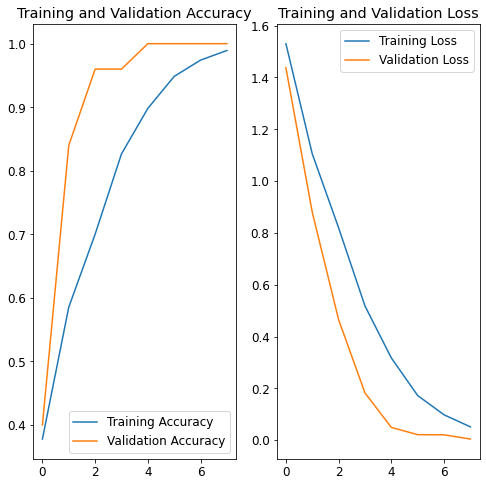

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history2.history['accuracy']

loss = history2.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Testing Loss')
plt.show()

### Getting test images

In [ ]:
test_path = "/content/drive/MyDrive/Capstone"
Path.BASE_PATH = test_path

In [ ]:
image = test_path + "/Test"
test = tf.keras.utils.image_dataset_from_directory(image, seed=123, image_size=(img_height, img_width), batch_size=BATCH_SIZE)

In [ ]:
model.evaluate(test)

### Exporting to TensorFlowLite model

In [ ]:
#module_selection = ("mobilenet_v1", 224, 1280)

In [ ]:
saved_model_dir = '/content/drive/MyDrive/Capstone'

tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/assets


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
tflite_models_dir = pathlib.Path("/content/drive/MyDrive/Capstone")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/MODEL_NAME
tflite_model_file.write_bytes(tflite_model)

25791516

In [ ]:
# Performing Post-training Quantisation
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/MODEL_NAME
tflite_model_quant_file.write_bytes(tflite_quant_model)

# Save the model.
with open('/content/drive/MyDrive/Capstone/tomato_quant_classifier.tflite', 'wb') as f:
  f.write(tflite_quant_model)

### Loading the model into an interprater

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
ls -lh {tflite_models_dir}

total 13M
drwx------ 2 root root 4.0K Apr 26 22:28 assets/
-rw------- 1 root root   71 Apr 26 19:30 label.txt
-rw------- 1 root root 155K May 13 01:20 saved_model.pb
drwx------ 2 root root 4.0K May 11 22:38 Test/
-rw------- 1 root root 6.2M May 13 01:20 tomato_disease_classifier
-rw------- 1 root root 6.2M May 13 01:20 tomato_quant_classifier.tflite
drwx------ 2 root root 4.0K May 13 01:20 variables/


In [ ]:
""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV1 image classifier"
model_meta.description = ("Identify the tomato crop disease in the "
                          "image from a set of 4,976 categories")
model_meta.version = "v1"
model_meta.author = "Stacy Sarfo"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

'Creates the metadata for an image classifier.'

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(160, 160))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 6 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("/content/drive/MyDrive/Capstone/label.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file(tflite_model_file)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["/content/drive/MyDrive/Capstone/label.txt"])
populator.populate()

In [ ]:
# def export_model(saver, model, input_node_names, output_node_name):
#     tf.train.write_graph(K.get_session().graph_def, 'out', \
#         MODEL_NAME + '_graph.pbtxt')

#     saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

#     freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
#         False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
#         "save/restore_all", "save/Const:0", \
#         'out/frozen_' + MODEL_NAME + '.pb', True, "")

#     input_graph_def = tf.GraphDef()
#     with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
#         input_graph_def.ParseFromString(f.read())

#     output_graph_def = optimize_for_inference_lib.optimize_for_inference(
#             input_graph_def, input_node_names, [output_node_name],
#             tf.float32.as_datatype_enum)

#     with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
#         f.write(output_graph_def.SerializeToString())

#     print("graph saved!")

In [ ]:
# # convert the model to TFLite
# !mkdir "tflite_models"
# TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# # Get the concrete function from the Keras model.
# run_model = tf.function(lambda x : reloaded(x))

# # Save the concrete function.
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
# )

# # Convert the model to standard TensorFlow Lite model
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converted_tflite_model = converter.convert()
# open(TFLITE_MODEL, "wb").write(converted_tflite_model)